<a href="https://colab.research.google.com/github/Xinsen-Zhang/LSTM-stack-predict/blob/master/LSTM%E4%BA%AC%E4%B8%9C%E6%96%B9%E8%82%A1%E7%A5%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tushare

     |████████████████████████████████| 174kB 49.1MB/s 
     |████████████████████████████████| 81kB 25.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/a0/e2/63/7af55ce7b4b398522ff486e7a80b379318817d029921c7c3cc
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built tushare simplejson


In [0]:
import tushare as ts
data = ts.get_today_ticks('600848')
data.to_csv('./jingdongfang.csv', index= False, header= False)

[Getting data:]####################################################################

In [0]:
data.head()

,time,price,pchange,change,volume,amount,type
0,15:00:00,30.08,-8.93,0.00,0,0,买盘
1,15:00:00,30.08,-8.93,-0.05,1410,4241280,卖盘
2,14:59:56,30.13,-8.78,0.00,0,0,买盘
3,14:59:26,30.13,-8.78,0.00,0,0,买盘
4,14:57:14,30.13,-8.78,0.00,0,0,买盘


In [0]:
data.shape

(4114, 7)

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import LSTM, Dropout, Dense
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler

In [0]:
plt.style.use('fivethirtyeight')

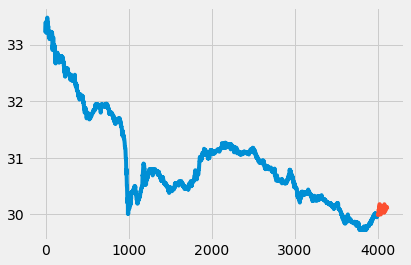

In [0]:
sc = MinMaxScaler()
time_order_data = data.iloc[::-1].reset_index()
price = time_order_data['price'].values
split_index = 4000
plt.plot(range(split_index), price[:split_index])
plt.plot(range(split_index, price.shape[0]), price[split_index:])
sc.fit(price.reshape(-1,1))
train_data = sc.transform(price[:split_index].reshape(-1,1))
test_data = sc.transform(price[split_index:].reshape(-1,1))
X_train = []
y_train = []
for i in range(10, train_data.shape[0]):
    X_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(*X_train.shape, 1)

In [0]:
model = Sequential()
model.add(LSTM(64, return_sequences= True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.05))
model.add(LSTM(64, return_sequences= True))
model.add(Dropout(0.05))
model.add(LSTM(64, return_sequences= True))
model.add(Dropout(0.05))
# model.add(LSTM(64, return_sequences= True))
# model.add(Dropout(0.05))
model.add(LSTM(64))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile('rmsprop', 'mean_squared_error')
model.summary()
model.fit(X_train, y_train, epochs= 25, batch_size= 128, verbose= True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
dropout_49 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
dropout_50 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 10, 64)            33024     
_________________________________________________________________
dropout_51 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 64)                33024     
__________

In [0]:
np.concatenate([train_data[-10:], test_data], axis= 0).shape

(499, 1)

In [0]:
X_test = []
y_test = []
test_data_ = np.concatenate([train_data[-10:], test_data], axis= 0)
for i in range(10, test_data_.shape[0]):
    X_test.append(test_data_[i-10:i, 0])
    y_test.append(test_data_[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape(*X_test.shape, 1)

In [0]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

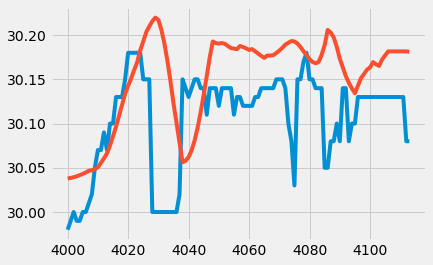

In [0]:
price = time_order_data['price'].values
# split_index = 4000
# plt.plot(range(split_index), price[:split_index])
plt.plot(range(split_index, price.shape[0]), price[split_index:])
plt.plot(range(split_index, price.shape[0]), predicted_stock_price)